In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
from scipy.stats import norm,multivariate_normal

import warnings
warnings.filterwarnings("ignore")


In [ ]:
# This is for create 2 dim synthetic dataset. 
# The distributional shift is created by a multivariate Gaussian. You can play with the mean, cov to create differnet shift
# The target 

In [3]:
# create unbiased dataset
xy = np.random.uniform(0,1,(10000,2))
label = []
def get_label(t):
    x = t[0]
    y = t[1]
    if y <= 0.5:
        return 0
    if y > 0.5:
        return 1

for t in xy:
    label.append(get_label(t))

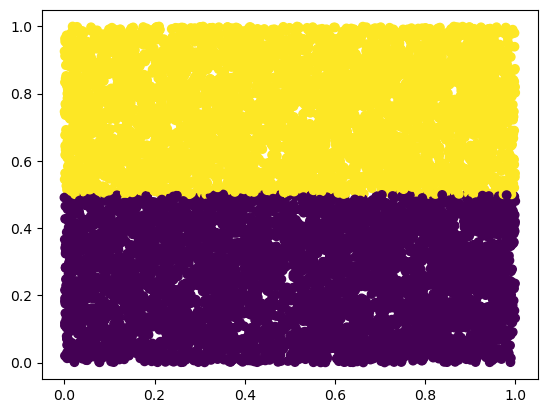

In [4]:
# different color means different y
plt.scatter(xy[:,0],xy[:,1],c = label)

In [9]:
# use gaussian to generate distribution shift
def get_gaussian_distribution(xy,mean,covariance):
    pdf = multivariate_normal(mean, covariance).pdf(xy)
    return pdf



In [26]:
mean = [0.8,0.8]
cov = [[0.1,0],[0,0.1]]

In [40]:
# sample 1000 data based on training 
sampled_xy = np.zeros((500,2))
sampled_ture_label = np.zeros((500,1))
sampled_prob = np.zeros((500,1))
sampled_prob_on_target = np.zeros((500,1))

pdf = get_gaussian_distribution(xy,mean,cov)
index_list = [i for i in range(len(xy))]
for i in range(500):
    index = random.choices(index_list,weights=pdf)[0]
    sampled_ture_label[i] = label[index]
    sampled_xy[i] = xy[index]
    sampled_prob[i] = pdf[index]/sum(pdf)
    sampled_prob_on_target[i] = 0.0001
    
    
train_data = np.concatenate((sampled_xy,sampled_ture_label,sampled_prob,sampled_prob_on_target),axis = 1)


sampled_xy = np.zeros((500,2))
sampled_ture_label = np.zeros((500,1))
sampled_prob = np.zeros((500,1))
sampled_prob_on_source = np.zeros((500,1))

pdf_uniform = np.ones(len(xy))
index_list = [i for i in range(len(xy))]
for i in range(500):
    index = random.choices(index_list,weights=pdf_uniform)[0]
    sampled_ture_label[i] = label[index]
    sampled_xy[i] = xy[index]
    sampled_prob[i] = pdf[index]/sum(pdf_uniform)
    
    sampled_prob_on_source[i] = multivariate_normal(mean, cov).pdf(xy[index])/sum(pdf)
    
    
test_data = np.concatenate((sampled_xy,sampled_ture_label,sampled_prob,sampled_prob_on_source),axis = 1)




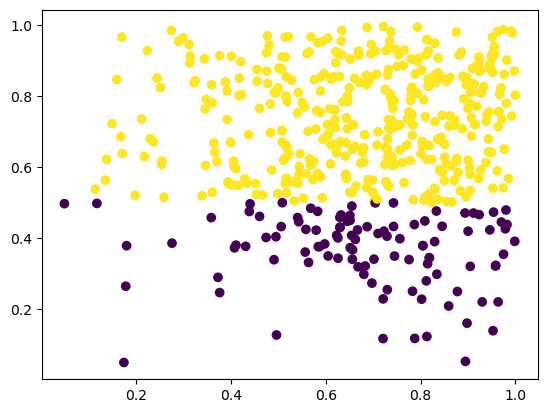

In [41]:
plt.scatter(train_data[:,0],train_data[:,1],c = train_data[:,2])

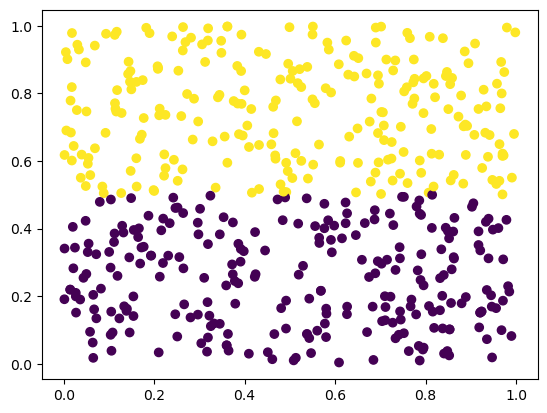

In [42]:
plt.scatter(test_data[:,0],test_data[:,1],c =test_data[:,2])

In [45]:
pd.DataFrame(train_data,columns = ['x0','x1','y','p_x','q_x']).to_csv('train_data.csv',index = False)

In [46]:
pd.DataFrame(test_data,columns = ['x0','x1','y','q_x','p_x']).to_csv('test_data.csv',index = False)

In [6]:
def sample_logging_data(xy,label,size,pdf,pdf2,mean_eval,cov_eval):
    sampled_xy = np.zeros((size,2))
    sampled_ture_label = np.zeros(size)
    sampled_action = np.zeros(size)
    
    sampled_xshift_prob = np.zeros(size)
    sampled_xshift_prob_for_eval = np.zeros(size)
    sampled_policy_prob = np.zeros(size)
    sampled_eval_policy_prob = np.zeros(size)
    
    sampled_reward = np.zeros(size)

    index_list = [i for i in range(len(xy))]
    for i in range(size):
        index = random.choices(index_list,weights=pdf)[0]
        sampled_xshift_prob[i] = pdf[index]
        sampled_xy[i] = xy[index]
        sampled_ture_label[i] = label[index]
        sampled_action[i],sampled_policy_prob[i] = take_action(label[index], policy_dict)
        sampled_eval_policy_prob[i] = eval_policy_dict[label[index]][int(sampled_action[i])]
        sampled_xshift_prob_for_eval[i] = multivariate_normal(mean_eval, cov_eval).pdf(sampled_xy[i])
        sampled_reward[i] = int(sampled_action[i] == label[index])
    sampled_xshift_prob_for_eval = sampled_xshift_prob_for_eval/sum(pdf2)
        
    return sampled_xy, sampled_action, sampled_reward, sampled_ture_label, sampled_policy_prob,sampled_eval_policy_prob, sampled_xshift_prob,sampled_xshift_prob_for_eval
        
        
        
        
    

In [7]:
def sample_data(xy,label,size,pdf,pdf2,mean_logging,cov_logging):
    sampled_xy = np.zeros((size,2))
    sampled_ture_label = np.zeros(size)
    sampled_action = np.zeros(size)
    
    sampled_xshift_prob = np.zeros(size)
    sampled_xshift_prob_for_logging = np.zeros(size)
    sampled_policy_prob = np.zeros(size)
    sampled_eval_policy_prob = np.zeros(size)
    
    sampled_reward = np.zeros(size)

    index_list = [i for i in range(len(xy))]
    for i in range(size):
        index = random.choices(index_list,weights=pdf2)[0]
        sampled_xshift_prob[i] = pdf2[index]
        sampled_xy[i] = xy[index]
        sampled_ture_label[i] = label[index]
        sampled_action[i],sampled_policy_prob[i] = take_action(label[index], policy_dict)
        sampled_eval_policy_prob[i] = eval_policy_dict[label[index]][int(sampled_action[i])]
        sampled_xshift_prob_for_logging[i] = multivariate_normal(mean_logging, cov_logging).pdf(sampled_xy[i])
        
        
        sampled_reward[i] = int(sampled_action[i] == label[index])
    sampled_xshift_prob_for_logging = sampled_xshift_prob_for_logging/sum(pdf)
    return sampled_xy, sampled_action, sampled_reward, sampled_ture_label, sampled_policy_prob,sampled_eval_policy_prob, sampled_xshift_prob, sampled_xshift_prob_for_logging
        
        

In [28]:
def p_xshift(train_x,test_x):
    from sklearn.linear_model import LogisticRegression
    X = np.concatenate((train_x,test_x),axis = 0)
#     X = np.sum(X,axis = 1,keepdims = True)
    Y = np.concatenate((np.ones(len(train_x)),np.zeros(len(test_x))),axis = 0)
    clf = LogisticRegression().fit(X,Y)
    return clf

def loggingpolicy(x,y):
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression().fit(x,y)
    return clf

In [30]:
def evaluate(sampled_xy, sampled_action, sampled_reward, \
             sampled_ture_label, sampled_policy_prob,\
             sampled_eval_policy_prob, sampled_xshift_prob,sampled_xshift_prob_for_eval,\
            sampled_xy_eval, sampled_action_eval, sampled_reward_eval, sampled_ture_label_eval, \
            sampled_policy_prob_eval,sampled_eval_policy_prob_eval, \
            sampled_xshift_prob_eval,mean,std,pdf2):
    
    
    
    ips_loss = []
    snips_loss = []
    ips_r_loss = []
    
    ips_loss_logging = []
    snips_loss_logging = []
    ips_r_loss_logging = []
    
    ips_loss_xshift = []
    snips_loss_xshift = []
    ips_r_loss_xshift = []
    
    ips_loss_both = []
    snips_loss_both = []
    ips_r_loss_both = []
    
    
    for i in range(10):
        eval_action = np.zeros(len(sampled_action))
        eval_action_prob = np.zeros(len(sampled_action))
        total_reward = 0
        for j in range(len(sampled_xy)):
            action, prob = take_action(sampled_ture_label_eval[i], eval_policy_dict)
            if action == sampled_ture_label_eval[i]:
                total_reward += 1
        total_reward = total_reward/len(sampled_xy)
        
        clf_xshift = p_xshift(sampled_xy,sampled_xy_eval)
        clf_logging = loggingpolicy(sampled_xy,sampled_action)
        
        logging = clf_logging.predict_proba(sampled_xy)[np.arange(len(sampled_xy)),np.array(sampled_action,np.int)]
        
        xshift_logging = clf_xshift.predict_proba(sampled_xy)
        r = xshift_logging[:,1]/xshift_logging[:,0]
        
        
        sampled_xshift_prob_eval = sampled_xshift_prob_for_eval
        
#         know all
        ips = sampled_eval_policy_prob/sampled_policy_prob * sampled_reward
        snips = sampled_eval_policy_prob/sampled_policy_prob * sampled_reward / np.mean(sampled_eval_policy_prob/sampled_policy_prob)
        ips_r = sampled_eval_policy_prob/sampled_policy_prob * (sampled_xshift_prob_eval/sampled_xshift_prob) * sampled_reward
        
        ips = sum(ips)/len(sampled_xy)
        snips = sum(snips)/len(sampled_xy)
        ips_r = sum(ips_r)/len(sampled_xy)
        
        ips_loss.append((ips-total_reward)**2)
        ips_r_loss.append((ips_r-total_reward)**2)
        snips_loss.append((snips-total_reward)**2)
        
        
#         unknow logging
        ips = sampled_eval_policy_prob/logging * sampled_reward
        snips = sampled_eval_policy_prob/logging * sampled_reward / np.mean(sampled_eval_policy_prob/logging)
        ips_r = sampled_eval_policy_prob/logging* (sampled_xshift_prob_eval/sampled_xshift_prob) * sampled_reward
        
        ips = sum(ips)/len(sampled_xy)
        snips = sum(snips)/len(sampled_xy)
        ips_r = sum(ips_r)/len(sampled_xy)
        
        ips_loss_logging.append((ips-total_reward)**2)
        ips_r_loss_logging.append((ips_r-total_reward)**2)
        snips_loss_logging.append((snips-total_reward)**2)
        
#         unknow xshift
        ips = sampled_eval_policy_prob/sampled_policy_prob * sampled_reward
        snips = sampled_eval_policy_prob/sampled_policy_prob * sampled_reward / np.mean(sampled_eval_policy_prob/sampled_policy_prob)
        ips_r = sampled_eval_policy_prob/sampled_policy_prob* r * sampled_reward
        
        ips = sum(ips)/len(sampled_xy)
        snips = sum(snips)/len(sampled_xy)
        ips_r = sum(ips_r)/len(sampled_xy)
        
        ips_loss_xshift.append((ips-total_reward)**2)
        ips_r_loss_xshift.append((ips_r-total_reward)**2)
        snips_loss_xshift.append((snips-total_reward)**2)
        
                
#         unknow both
        ips = sampled_eval_policy_prob/logging * sampled_reward
        snips = sampled_eval_policy_prob/logging * sampled_reward / np.mean(sampled_eval_policy_prob/logging)
        
        ips_r = sampled_eval_policy_prob/logging* r * sampled_reward
        ips = sum(ips)/len(sampled_xy)
        snips = sum(snips)/len(sampled_xy)
        ips_r = sum(ips_r)/len(sampled_xy)
        
        ips_loss_both.append((ips-total_reward)**2)
        ips_r_loss_both.append((ips_r-total_reward)**2)
        snips_loss_both.append((snips-total_reward)**2)
        
        
    return np.mean(ips_loss),np.mean(snips_loss),np.mean(ips_r_loss),\
            np.mean(ips_loss_logging),np.mean(snips_loss_logging),np.mean(ips_r_loss_logging),\
            np.mean(ips_loss_xshift),np.mean(snips_loss_xshift),np.mean(ips_r_loss_xshift),\
            np.mean(ips_loss_both),np.mean(snips_loss_both),np.mean(ips_r_loss_both)
        
        
            
        
        
        
        
        
        
        





In [70]:
def vis_gaussian(mean,cov):
    x, y = np.mgrid[0:1:.001, 0:1:.001]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mean, cov)
#     fig2 = plt.figure()
#     ax2 = fig2.add_subplot(111)
    plt.contourf(x, y, rv.pdf(pos))
    plt.colorbar()
    plt.show()

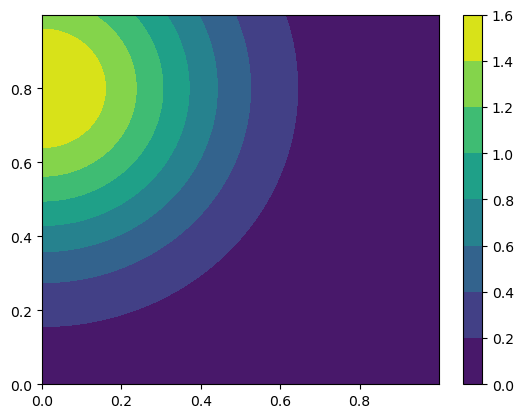

In [71]:
policy_dict = {
    0:[0.9,0.1/3,0.1/3,0.1/3],
    1:[0.2/3,0.8,0.2/3,0.2/3],
    2:[0.3/3,0.3/3,0.7,0.7/3],
    3:[0.4/3,0.4/3,0.4/3,0.6],
}



eval_policy_dict = {
    0:[0.4,0.6/3,0.6/3,0.6/3],
    1:[0.5/3,0.5,0.5/3,0.5/3],
    2:[0.1/3,0.1/3,0.9,0.1/3],
    3:[0.7/3,0.7/3,0.7/3,0.3],
}
# a = 0.8
# b = 20
size = 5000

mean_logging = [0.,0.8]
covariance_logging = [[0.1,0],[0,0.1]]

mean_eval = [0.5,0.5]
covariance_eval = [[10,0],[0,10]]
vis_gaussian(mean_logging,covariance_logging)


mean, [0.5, 0.9]
cov, [[0.1, 0], [0, 0.1]]


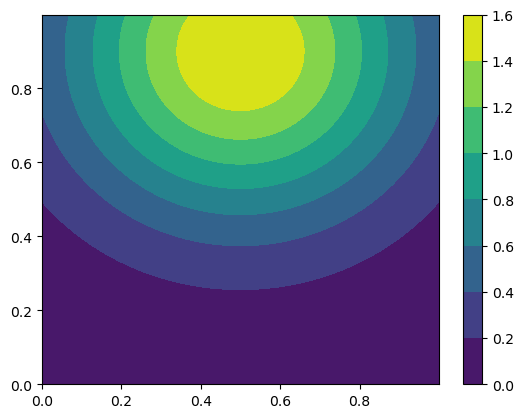

mean, [0.5, 0.9]
cov, [[0.05, 0], [0, 0.05]]


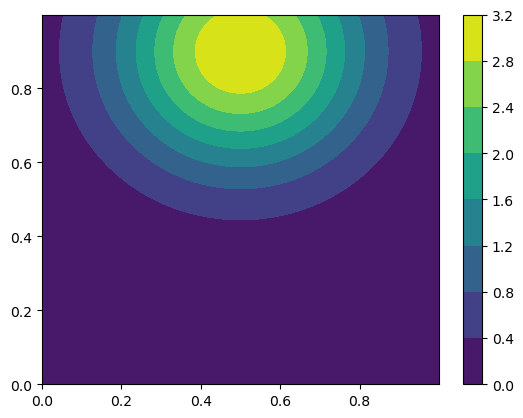

mean, [0.5, 0.9]
cov, [[0.2, 0], [0, 0.2]]


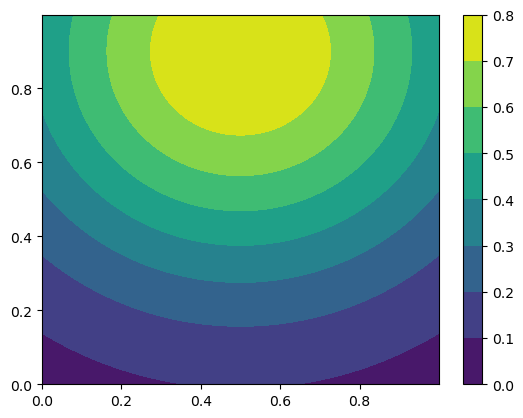

mean, [0.5, 0.9]
cov, [[0.4, 0], [0, 0.4]]


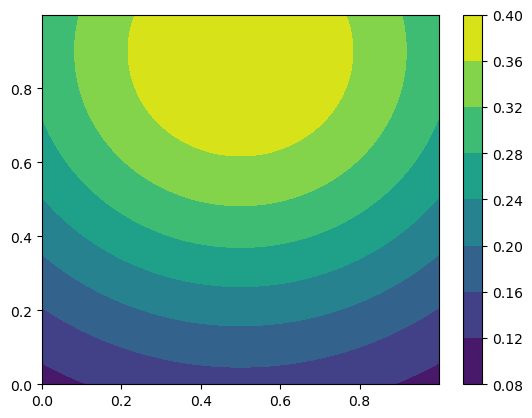

mean, [0.8, 0.8]
cov, [[0.1, 0], [0, 0.1]]


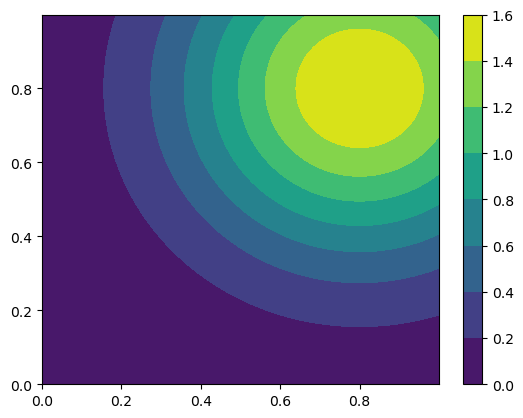

mean, [0.8, 0.8]
cov, [[0.05, 0], [0, 0.05]]


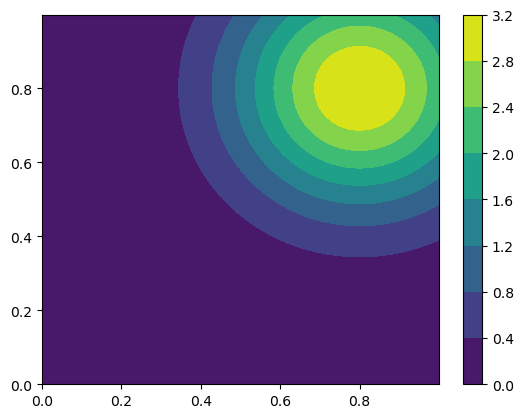

mean, [0.8, 0.8]
cov, [[0.2, 0], [0, 0.2]]


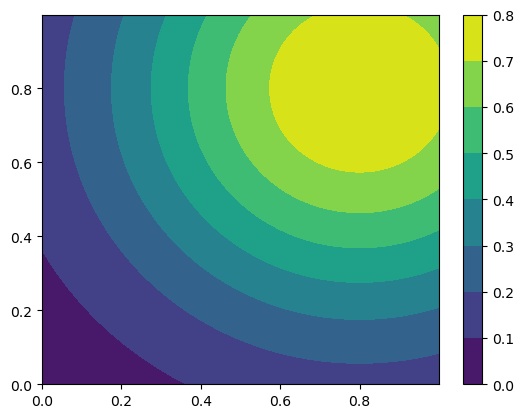

mean, [0.8, 0.8]
cov, [[0.4, 0], [0, 0.4]]


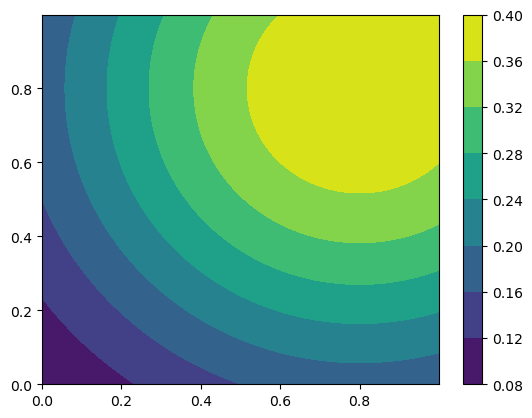

mean, [0.9, 0.9]
cov, [[0.1, 0], [0, 0.1]]


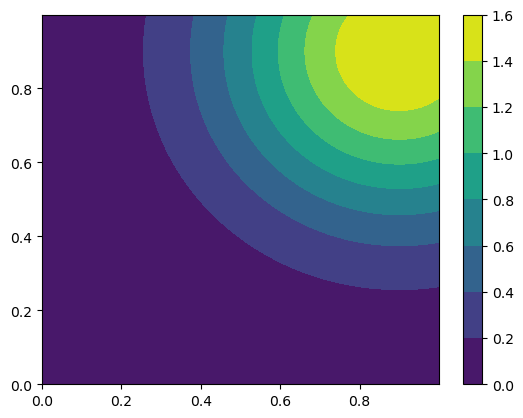

mean, [0.9, 0.9]
cov, [[0.05, 0], [0, 0.05]]


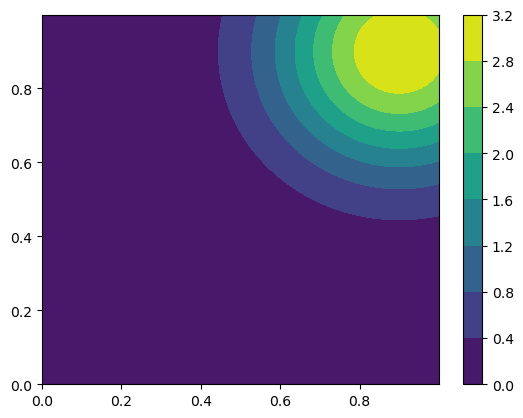

mean, [0.9, 0.9]
cov, [[0.2, 0], [0, 0.2]]


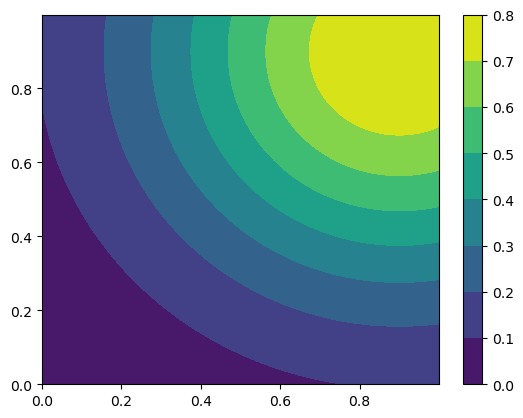

mean, [0.9, 0.9]
cov, [[0.4, 0], [0, 0.4]]


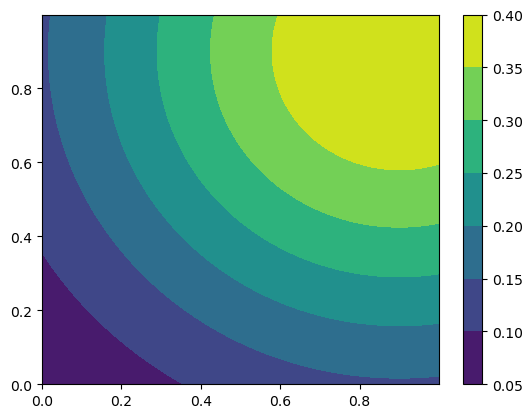

In [73]:
for m_i in range(len(mean_logging_list)):
    for v_i in range(len(covariance_logging_list)):
        mean_logging = mean_logging_list[m_i]
        covariance_logging = covariance_logging_list[v_i]
        print('mean,',mean_logging)
        print('cov,',covariance_logging)
        vis_gaussian(mean_logging,covariance_logging)
        

In [13]:
# sample_xy, action, reward, weight



In [14]:
from ope_v3 import *


class WEIGHT_DATA_SET(data.Dataset):
    '''
    dataset class with instance weight 
    '''
    def __init__(self, data,reward, weights):
        '''
        weights are same dimensional witi original data
        '''
        self.data = torch.tensor(data)
        self.reward = torch.tensor(reward)
        self.weights = torch.tensor(weights)

    def __getitem__(self, index):
        img = self.data[index] 
        target = self.reward[index]
        weight = self.weights[index]
        return img, target, weight

    def __len__(self):
        return len(self.data)

# r is xshift weight
# w is policy shift weight
def train_robust_regression(feature,action,reward,eval_xshift, logging_xshift,eval_policy,logging_policy,
                           dm=False,xshift_known = True, policy_known = True,use_xshift = True):
#     print('train models with true density ratios')
    Myy_robust_list = []
    Myx_robust_list = []
    model_robust_list = []
    for i in range(4):
        ## generate training set for action i

        idx = (action == i)


        data_i = feature[idx]
        reward_i = reward[idx]
        eval_xshift_i = eval_xshift[idx]
        logging_xshift_i = logging_xshift[idx]
        eval_policy_i = eval_policy[idx]
        logging_policy_i = logging_policy[idx]

        train_size = len(data_i)

        if xshift_known:
            r = logging_xshift_i/eval_xshift_i
        if policy_known:
            w = logging_policy_i/eval_policy_i
        if use_xshift:
            w = r * w
        
        if dm:
            w = torch.ones(len(data_i))

        weight_st = my_bound(w)
        weighted_train = WEIGHT_DATA_SET(data_i,reward_i, w)

        train_model = Net()

        validate_size = int(0.1*train_size)

        validate_loader = data.DataLoader(data.Subset(weighted_train, range(0, validate_size)),
            batch_size=32, shuffle=True)
        # 10% validation set
        train_loader = data.DataLoader(data.Subset(weighted_train, range(validate_size, train_size)),
            batch_size=32, shuffle=True, )

        train_model, Myy, Myx, _, _, _ = train_validate_test(args,args.lr_robust, args.epochs_training, "regression", 'cpu', 'False', train_model,
            train_loader, None , validate_loader, 4, 0.000, testflag = False)

        model_robust_list.append(train_model)
        Myy_robust_list.append(Myy)
        Myx_robust_list.append(Myx)
    return model_robust_list, Myy_robust_list, Myx_robust_list




In [15]:
# model_robust_list, Myy_robust_list, Myx_robust_list = train_robust_regression(sampled_xy,sampled_action,sampled_reward,sampled_xshift_prob_for_eval
#                         ,sampled_xshift_prob,sampled_eval_policy_prob,sampled_policy_prob,
#                            dm=False,xshift_known = True, policy_known = True,use_xshift = True)

In [16]:
def predict_regression(model_robust_list, Myy_robust_list, Myx_robust_list,sampled_xy,sampled_action,sampled_xshift_prob_for_eval
                        ,sampled_xshift_prob,sampled_eval_policy_prob,sampled_policy_prob,
                           dm = False,xshift_known = True, policy_known = True,use_xshift = True):
    
    if xshift_known:
        r = sampled_xshift_prob/sampled_xshift_prob_for_eval
        
    if policy_known:
        w = sampled_policy_prob/sampled_eval_policy_prob
    
    if use_xshift:
        w = r*w
    if dm:
        w = torch.tensor([1])
    
    weight_st = my_bound(w)
    
    output = model_robust_list[int(sampled_action)](torch.tensor(sampled_xy).unsqueeze(0))

    Myy = Myy_robust_list[int(sampled_action)]
    Myx = Myx_robust_list[int(sampled_action)]
    meanY, varY = ru.predict_regression(torch.tensor(weight_st), Myy, Myx, output, mean0, var0)
    return meanY.detach().numpy()
        
        
        

In [17]:
def evaluate_robust(sampled_xy, sampled_action, sampled_reward, sampled_ture_label, \
        sampled_policy_prob,sampled_eval_policy_prob, \
        sampled_xshift_prob,sampled_xshift_prob_for_eval,\
        sampled_xy_eval, sampled_action_eval, sampled_reward_eval, sampled_ture_label_eval, \
        sampled_policy_prob_eval,sampled_eval_policy_prob_eval, \
        sampled_xshift_prob_eval,sampled_xshift_prob_for_logging,dm = False,use_xshift = True):
    
    model_robust_list, Myy_robust_list, Myx_robust_list = train_robust_regression(sampled_xy,sampled_action,sampled_reward,sampled_xshift_prob_for_eval
                        ,sampled_xshift_prob,sampled_eval_policy_prob,sampled_policy_prob,
                           dm=dm, use_xshift = use_xshift)
    
#     sample action 
    reg_loss = []
    triple_loss = []
    triple_r_loss = []
    for t in range(1):
        regression_list = []
        triple_r_list = []
        triple_list = []
        total_reward = 0
        for i in range(len(sampled_xy_eval)):
            action, prob = take_action(sampled_ture_label_eval[i], eval_policy_dict)
            if action == sampled_ture_label_eval[i]:
                total_reward += 1
            tmp_eval = predict_regression(model_robust_list, Myy_robust_list, Myx_robust_list,sampled_xy_eval[i],
                               action,sampled_xshift_prob_eval[i]
                        ,sampled_xshift_prob_for_logging[i],prob,policy_dict[sampled_ture_label_eval[i]][action],dm = dm,use_xshift = use_xshift)
            regression_list.append(tmp_eval)

            #     triple
            
            rw = my_bound(sampled_xshift_prob_for_eval[i]/sampled_xshift_prob[i] \
                          * sampled_eval_policy_prob[i]/sampled_policy_prob[i])
            w = my_bound(sampled_eval_policy_prob[i]/sampled_policy_prob[i])

            
            tmp = predict_regression(model_robust_list, Myy_robust_list, Myx_robust_list,sampled_xy[i],
                           sampled_action[i],sampled_xshift_prob_for_eval[i]
                    ,sampled_xshift_prob[i],sampled_eval_policy_prob[i],sampled_policy_prob[i],dm = dm,use_xshift = use_xshift)

            triple_r_list.append(rw*(sampled_reward[i] - tmp) + tmp_eval)

            triple_list.append(w*(sampled_reward[i] - tmp) + tmp_eval)


        triple_r = np.mean(triple_r_list)
        triple = np.mean(triple_list)
        robust = np.mean(regression_list)
        GT = total_reward/len(triple_r_list)
        reg_loss.append((robust - GT)**2)
        triple_loss.append((triple - GT)**2)
        triple_r_loss.append((triple_r - GT)**2)
    
    return np.mean(reg_loss),np.mean(triple_loss),np.mean(triple_r_loss)



In [19]:
# evaluate_robust(sampled_xy, sampled_action, sampled_reward, sampled_ture_label, \
#         sampled_policy_prob,sampled_eval_policy_prob, \
#         sampled_xshift_prob,sampled_xshift_prob_for_eval,\
#         sampled_xy_eval, sampled_action_eval, sampled_reward_eval, sampled_ture_label_eval, \
#         sampled_policy_prob_eval,sampled_eval_policy_prob_eval, \
#         sampled_xshift_prob_eval,sampled_xshift_prob_for_logging,dm = False,use_xshift = False)

In [51]:
model_list = [
    'known ips',
    'known snips',
    'known ips-r',
    'unknown ips',
    'unknown snips',
    'unknown ips-r',
    'known dm',
    'known dmdr',
    'known dmdr-r',
    'known robust without xshift',
    'known triple without xshift',
    'known triple-r without xshift',
    'known robust',
    'known triple',
    'known triple-r',
    'unknown dm',
    'unknown dmdr',
    'unknown dmdr-r',
    'unknown robust without xshift',
    'unknown triple without xshift',
    'unknown triple-r without xshift',
    'unknown robust',
    'unknown triple',
    'unknown triple-r'
]
len(model_list)

24

In [77]:


policy_dict = {
    0:[0.9,0.1/3,0.1/3,0.1/3],
    1:[0.2/3,0.8,0.2/3,0.2/3],
    2:[0.3/3,0.3/3,0.7,0.7/3],
    3:[0.4/3,0.4/3,0.4/3,0.6],
}



eval_policy_dict = {
    0:[0.4,0.6/3,0.6/3,0.6/3],
    1:[0.5/3,0.5,0.5/3,0.5/3],
    2:[0.1/3,0.1/3,0.9,0.1/3],
    3:[0.7/3,0.7/3,0.7/3,0.3],
}


size = 5000

mean_logging_list =[[0.6,0.6], [0.8,0.8]]
covariance_logging_list = [[[0.2,0],[0,0.2]],[[0.4,0],[0,0.4]]]

mean_eval = [0.5,0.5]
covariance_eval = [[10,0],[0,10]]
# vis_gaussian(mean_logging,covariance_logging)

for size in [100,200]:
    frame = {}
    frame['name'] = model_list
    for m_i in range(len(mean_logging_list)):
        for v_i in range(len(covariance_logging_list)):
            mean_logging = mean_logging_list[m_i]
            covariance_logging = covariance_logging_list[v_i]
            
            ips = []
            snips = []
            ips_r = []

            ips_logging = []
            snips_logging = []
            ips_r_logging = []

            ips_xshift = []
            snips_xshift = []
            ips_r_xshift = []

            ips_both = []
            snips_both = []
            ips_r_both = []

            dm = []
            drrobust = []
            drrobust_r = []

            robust_noxshift = []
            triple_noxshift = []
            triple_r_noxshift = []

            robust = []
            triple = []
            triple_r = []
            
            dm_unknown = []
            drrobust_unknown = []
            drrobust_r_unknown = []

            robust_noxshift_unknown = []
            triple_noxshift_unknown = []
            triple_r_noxshift_unknown = []

            robust_unknown = []
            triple_unknown = []
            triple_r_unknown = []






            for i in range(10):
                pdf = get_gaussian_distribution(xy,mean_logging,covariance_logging)
                pdf_norm = pdf/sum(pdf)
                pdf2 = get_gaussian_distribution(xy,mean_eval,covariance_eval)
                pdf2_norm = pdf2/sum(pdf2)
                sampled_xy, sampled_action, sampled_reward, sampled_ture_label, \
                    sampled_policy_prob,sampled_eval_policy_prob, \
                    sampled_xshift_prob,sampled_xshift_prob_for_eval  = sample_logging_data(xy,label,size,pdf_norm,pdf2,mean_eval,covariance_eval)

                sampled_xy_eval, sampled_action_eval, sampled_reward_eval, sampled_ture_label_eval, \
                    sampled_policy_prob_eval,sampled_eval_policy_prob_eval, \
                    sampled_xshift_prob_eval,sampled_xshift_prob_for_logging = sample_data(xy,label,size,pdf,pdf2_norm,mean_logging,covariance_logging)
            #     ips, snips, ips_r = [], [], []
                res = evaluate(sampled_xy, sampled_action, sampled_reward, \
                             sampled_ture_label, sampled_policy_prob,\
                             sampled_eval_policy_prob, sampled_xshift_prob,sampled_xshift_prob_for_eval,\
                            sampled_xy_eval, sampled_action_eval, sampled_reward_eval, sampled_ture_label_eval, \
                            sampled_policy_prob_eval,sampled_eval_policy_prob_eval, \
                            sampled_xshift_prob_eval,mean_eval,covariance_eval,pdf2)
                
                ips.append(res[0])
                snips.append(res[1])
                ips_r.append(res[2])

                ips_logging.append(res[3])
                snips_logging.append(res[4])
                ips_r_logging.append(res[5])

                ips_xshift.append(res[6])
                snips_xshift.append(res[7])
                ips_r_xshift.append(res[8])

                ips_both.append(res[9])
                snips_both.append(res[10])
                ips_r_both.append(res[11])



                res = evaluate_robust(sampled_xy, sampled_action, sampled_reward, sampled_ture_label, \
                    sampled_policy_prob,sampled_eval_policy_prob, \
                    sampled_xshift_prob,sampled_xshift_prob_for_eval,\
                    sampled_xy_eval, sampled_action_eval, sampled_reward_eval, sampled_ture_label_eval, \
                    sampled_policy_prob_eval,sampled_eval_policy_prob_eval, \
                    sampled_xshift_prob_eval,sampled_xshift_prob_for_logging,dm = True,use_xshift = False)
                dm.append(res[0])
                drrobust.append(res[1])
                drrobust_r.append(res[2])

                res = evaluate_robust(sampled_xy, sampled_action, sampled_reward, sampled_ture_label, \
                    sampled_policy_prob,sampled_eval_policy_prob, \
                    sampled_xshift_prob,sampled_xshift_prob_for_eval,\
                    sampled_xy_eval, sampled_action_eval, sampled_reward_eval, sampled_ture_label_eval, \
                    sampled_policy_prob_eval,sampled_eval_policy_prob_eval, \
                    sampled_xshift_prob_eval,sampled_xshift_prob_for_logging,dm = False,use_xshift = False)

                robust_noxshift.append(res[0])
                triple_noxshift.append(res[1])
                triple_r_noxshift.append(res[2])

                res = evaluate_robust(sampled_xy, sampled_action, sampled_reward, sampled_ture_label, \
                    sampled_policy_prob,sampled_eval_policy_prob, \
                    sampled_xshift_prob,sampled_xshift_prob_for_eval,\
                    sampled_xy_eval, sampled_action_eval, sampled_reward_eval, sampled_ture_label_eval, \
                    sampled_policy_prob_eval,sampled_eval_policy_prob_eval, \
                    sampled_xshift_prob_eval,sampled_xshift_prob_for_logging,dm = False,use_xshift = True)

                robust.append(res[0])
                triple.append(res[1])
                triple_r.append(res[2])
            
            
                clf_xshift = p_xshift(sampled_xy,sampled_xy_eval)
                clf_logging = loggingpolicy(sampled_xy,sampled_action)

                sampled_policy_prob_pred = clf_logging.predict_proba(sampled_xy)[np.arange(len(sampled_xy)),np.array(sampled_action,np.int)]
                sampled_xshift_prob_pred = clf_xshift.predict_proba(sampled_xy)[:,0]
                sampled_xshift_prob_for_eval_pred= clf_xshift.predict_proba(sampled_xy)[:,1]

                sampled_policy_prob_eval_pred = clf_logging.predict_proba(sampled_xy_eval)[np.arange(len(sampled_xy_eval)),np.array(sampled_action_eval,np.int)]
                sampled_xshift_prob_eval_pred = clf_xshift.predict_proba(sampled_xy_eval)[:,1]
                sampled_xshift_prob_for_logging_pred= clf_xshift.predict_proba(sampled_xy_eval)[:,0]
                
#                 unknown
                res = evaluate_robust(sampled_xy, sampled_action, sampled_reward, sampled_ture_label, \
                    sampled_policy_prob_pred,sampled_eval_policy_prob, \
                    sampled_xshift_prob_pred,sampled_xshift_prob_for_eval_pred,\
                    sampled_xy_eval, sampled_action_eval, sampled_reward_eval, sampled_ture_label_eval, \
                    sampled_policy_prob_eval_pred,sampled_eval_policy_prob_eval, \
                    sampled_xshift_prob_eval_pred,sampled_xshift_prob_for_logging_pred,dm = True,use_xshift = False)
                dm_unknown.append(res[0])
                drrobust_unknown.append(res[1])
                drrobust_r_unknown.append(res[2])

                res = evaluate_robust(sampled_xy, sampled_action, sampled_reward, sampled_ture_label, \
                    sampled_policy_prob_pred,sampled_eval_policy_prob, \
                    sampled_xshift_prob_pred,sampled_xshift_prob_for_eval_pred,\
                    sampled_xy_eval, sampled_action_eval, sampled_reward_eval, sampled_ture_label_eval, \
                    sampled_policy_prob_eval_pred,sampled_eval_policy_prob_eval, \
                    sampled_xshift_prob_eval_pred,sampled_xshift_prob_for_logging_pred,dm = False,use_xshift = False)

                robust_noxshift_unknown.append(res[0])
                triple_noxshift_unknown.append(res[1])
                triple_r_noxshift_unknown.append(res[2])

                res = evaluate_robust(sampled_xy, sampled_action, sampled_reward, sampled_ture_label, \
                    sampled_policy_prob_pred,sampled_eval_policy_prob, \
                    sampled_xshift_prob_pred,sampled_xshift_prob_for_eval_pred,\
                    sampled_xy_eval, sampled_action_eval, sampled_reward_eval, sampled_ture_label_eval, \
                    sampled_policy_prob_eval_pred,sampled_eval_policy_prob_eval, \
                    sampled_xshift_prob_eval_pred,sampled_xshift_prob_for_logging_pred,dm = False,use_xshift = True)

                robust_unknown.append(res[0])
                triple_unknown.append(res[1])
                triple_r_unknown.append(res[2])

            
            
            
            
            print('size,',size)
            print(mean_logging)
            print(covariance_logging)
            
            policy_name = str(mean_logging) + '_' + str(covariance_logging)
            
            result_list = []
            
            
            print('all known')
            print(np.mean(ips))
            result_list.append(np.mean(ips))
            print(np.mean(snips))
            result_list.append(np.mean(snips))
            print(np.mean(ips_r))
            result_list.append(np.mean(ips_r))

            print('unknown all')
            print(np.mean(ips_both))
            result_list.append(np.mean(ips_both))
            print(np.mean(snips_both))
            result_list.append(np.mean(snips_both))
            print(np.mean(ips_r_both))
            result_list.append(np.mean(ips_r_both))

            print('dmrobust')
            print(np.mean(dm))
            result_list.append(np.mean(dm))
            print(np.mean(drrobust))
            result_list.append(np.mean(drrobust))
            print(np.mean(drrobust_r))
            result_list.append(np.mean(drrobust_r))

            print('robust without xshift')
            print(np.mean(robust_noxshift))
            result_list.append(np.mean(robust_noxshift))
            print(np.mean(triple_noxshift))
            result_list.append(np.mean(triple_noxshift))
            print(np.mean(triple_r_noxshift))
            result_list.append(np.mean(triple_r_noxshift))

            print('robust with xshift')
            print(np.mean(robust))
            result_list.append(np.mean(robust))
            print(np.mean(triple))
            result_list.append(np.mean(triple))
            print(np.mean(triple_r))
            result_list.append(np.mean(triple_r))
#             unknown
            print('dmrobust unknown')
            print(np.mean(dm_unknown))
            result_list.append(np.mean(dm_unknown))
            print(np.mean(drrobust_unknown))
            result_list.append(np.mean(drrobust_unknown))
            print(np.mean(drrobust_r_unknown))
            result_list.append(np.mean(drrobust_r_unknown))

            print('robust without xshift unknown')
            print(np.mean(robust_noxshift_unknown))
            result_list.append(np.mean(robust_noxshift_unknown))
            print(np.mean(triple_noxshift_unknown))
            result_list.append(np.mean(triple_noxshift_unknown))
            print(np.mean(triple_r_noxshift_unknown))
            result_list.append(np.mean(triple_r_noxshift_unknown))

            print('robust with xshift unknown')
            print(np.mean(robust_unknown))
            result_list.append(np.mean(robust_unknown))
            print(np.mean(triple_unknown))
            result_list.append(np.mean(triple_unknown))
            print(np.mean(triple_r_unknown))
            result_list.append(np.mean(triple_r_unknown))
            frame[policy_name] = result_list
    
    frame = pd.DataFrame(frame).round(4)
    frame.to_csv('result/' + str(size)+'.csv',index = False)
            
            
    








#             vis_gaussian(mean_logging,covariance_logging)
#             plt.scatter(sampled_xy[:,0],sampled_xy[:,1],c = sampled_ture_label + 1)



            # for k in range(4):
            #     print(sum(sampled_ture_label==k))
            # for k in range(4):
            #     print(sum(sampled_ture_label_eval==k))
            # print(' ')
            # for k in range(4):
            #     print(sum(sampled_ture_label==k)/sum(sampled_ture_label_eval==k))




size, 100
[0.6, 0.6]
[[0.2, 0], [0, 0.2]]
all known
0.054274676721151424
0.05581345468147823
0.05444935602827773
unknown all
0.22920987885541427
0.13277605218201916
0.23940883920874595
dmrobust
0.09139998099144506
0.002711606994322436
0.004119333752717104
robust without xshift
0.08406796751211157
0.006124867418438972
0.010005039789229031
robust with xshift
0.08060457076223784
0.006590031614089881
0.01178373144297555
dmrobust unknown
0.08242911859366948
0.1473199035968554
0.14674273710195435
robust without xshift unknown
0.06890040137098771
0.13145449309204366
0.1292255882294576
robust with xshift unknown
0.07006902373750025
0.12810503206799204
0.12400027237481741
size, 100
[0.6, 0.6]
[[0.4, 0], [0, 0.4]]
all known
0.05171448503243892
0.05183460086203283
0.0521275855170145
unknown all
0.2240286716596524
0.12301578412135612
0.2374131364598803
dmrobust
0.11024237470437367
0.004653585179905519
0.00507075234944695
robust without xshift
0.08962334273195341
0.010797186812369033
0.011233875221